In [2]:
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from math import log, pi, exp
from tqdm import tqdm
from sklearn.datasets import make_s_curve

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


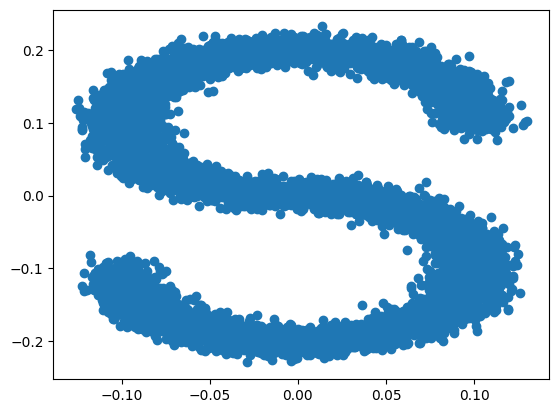

In [4]:
# dataset
s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
s_curve = torch.from_numpy(s_curve).to(torch.float32)
plt.scatter(s_curve[:, 0], s_curve[:, 1])
dataset = torch.Tensor(s_curve).float()


In [5]:
num_steps = 10
beta = torch.linspace(-6, 6, num_steps)
beta = torch.sigmoid(beta) * 0.005

alpha = 1 - beta
alpha_tilde = torch.cumprod(alpha, dim=0)
alpha_tilde_prev = torch.cat([torch.ones(1), alpha_tilde[:-1]], dim=0)
alpha_tilde_sqrt = torch.sqrt(alpha_tilde)
one_minus_alpha_tilde_sqrt = torch.sqrt(1-alpha_tilde)

beta = beta.to(device)
alpha = alpha.to(device)
alpha_tilde = alpha_tilde.to(device)
alpha_tilde_sqrt = alpha_tilde_sqrt.to(device)
one_minus_alpha_tilde_sqrt = one_minus_alpha_tilde_sqrt.to(device)

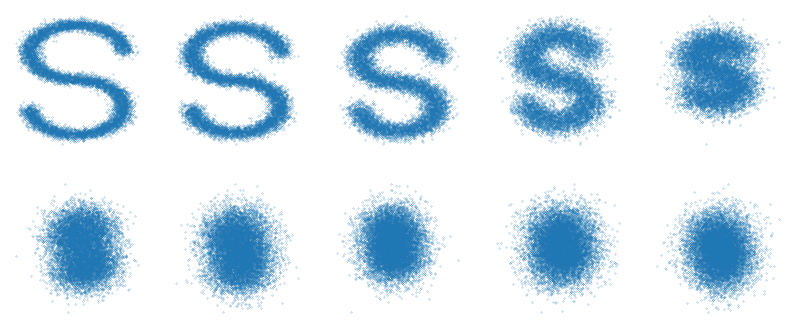

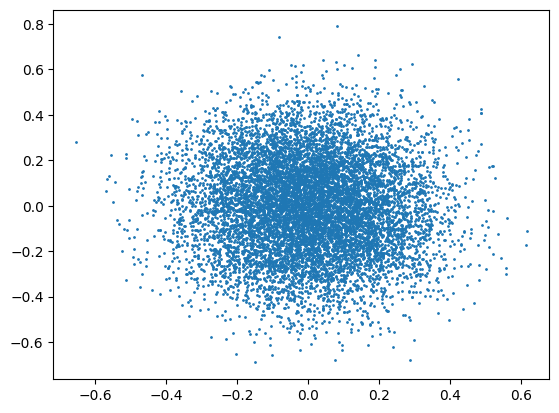

In [6]:
# test
img = s_curve.to(device)
def get_xt(x0, t):
    return x0 * alpha_tilde_sqrt[t] + torch.randn_like(x0) * one_minus_alpha_tilde_sqrt[t]

rows = 2
cols = num_steps // rows
fig, axs = plt.subplots(rows, cols, figsize=(10, 4))

for step in range(0, num_steps):
    noisy_image = get_xt(img, step).cpu()
    axs[step // cols][step % cols].scatter(noisy_image[:, 0], noisy_image[:, 1], s=0.03)
    axs[step // cols][step % cols].set_axis_off()
    
plt.figure(2)
last_img = get_xt(img, num_steps-1).cpu()
plt.scatter(last_img[:, 0], last_img[:, 1], s=1)

In [8]:
class PredictNoise(nn.Module):
    def __init__(self, n_steps, n_channels, hidden_dim=256):
        super(PredictNoise, self).__init__()
        
        self.linear1 = nn.Linear(n_channels, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, n_channels)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.step_embedding1 = nn.Embedding(n_steps, hidden_dim)
        self.step_embedding2 = nn.Embedding(n_steps, hidden_dim)
        self.step_embedding3 = nn.Embedding(n_steps, hidden_dim)
        
    # We use xt and step t to predict the noise
    # !!! Note that the noise is not the one added from xt-1 to xt. It is the combination of many noise.
    def forward(self, xt, t):
        x = self.linear1(xt)
        x = x + self.step_embedding1(t)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = x + self.step_embedding2(t)
        x = self.relu2(x)
        
        x = self.linear3(x)
        x = x + self.step_embedding3(t)
        x = self.relu3(x)
        
        x = self.linear4(x)

        return x

In [9]:
def generate_image(model):
    xt = []
    cur_x = torch.randn_like(s_curve).to(device)
    xt.append(cur_x.cpu().detach().numpy())
    
    for t in reversed(range(num_steps)):
        epsilon_theta = model(cur_x, torch.tensor([t]).to(device))
        mu_theta = 1 / alpha[t].sqrt() * (cur_x - beta[t] / one_minus_alpha_tilde_sqrt[t] * epsilon_theta)
        # sample
        cur_x = mu_theta + torch.randn_like(cur_x) * beta[t].sqrt()   # the value beta[t].sqrt() is hold fixed
        xt.append(cur_x.cpu().detach().numpy())
    return xt

[[ 0.8548483   0.77289873]
 [ 0.39343163 -1.1118957 ]
 [ 1.632142    0.12044788]
 ...
 [-0.7346312   1.0651178 ]
 [ 1.4202551  -1.1088649 ]
 [ 0.64483064 -0.87620455]]


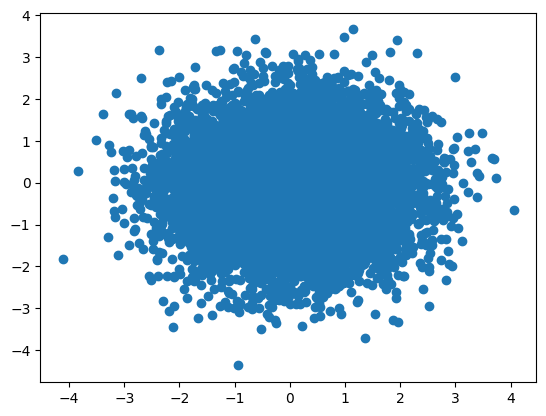

In [10]:
test_model = PredictNoise(num_steps, 2).to(device)
imgs = generate_image(test_model)
print(imgs[-1])
plt.scatter(imgs[-1][:, 0], imgs[-1][:, 1])

In [156]:
torch.cuda.is_available()

True

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:28<00:00,  3.54it/s]


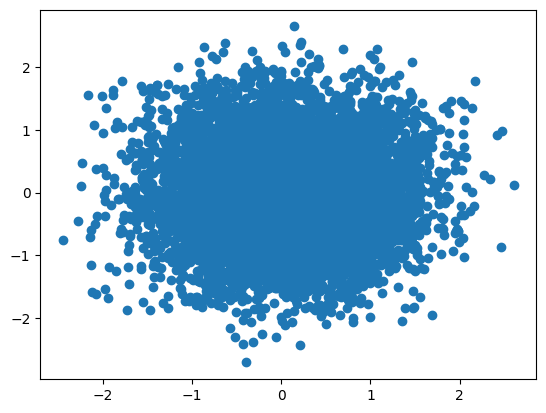

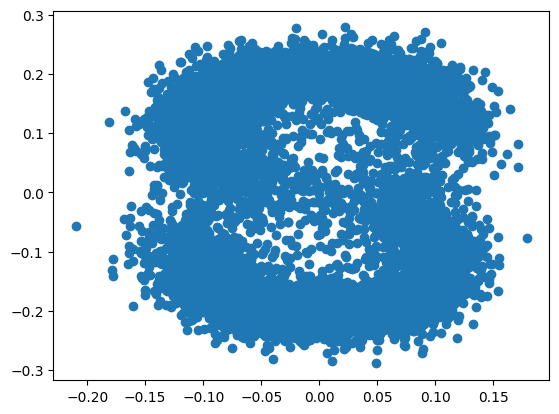

In [11]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = PredictNoise(num_steps, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
iters = 101
for iter in tqdm(range(iters)):
    iter_loss = 0
    for data in dataloader:
        x0 = data.to(device)
        
#         t = torch.randint(0, num_steps, size=(batch_size, )).to(device)
        t = torch.randint(0, num_steps, size=(batch_size//2,))
        t = torch.cat([t, num_steps-1-t], dim=0).to(device)
        a = alpha_tilde_sqrt[t].unsqueeze(-1)
        one_minus_a = one_minus_alpha_tilde_sqrt[t].unsqueeze(-1)
        
        # generate a random noise as target
        epsilon = torch.randn_like(x0).to(device)
        # now we predict it given xt and t
        xt = a * x0 + one_minus_a * epsilon
        epsilon_theta = model(xt, t)

        loss = (epsilon_theta - epsilon).square().mean()
        iter_loss += loss.cpu().data
        
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
       
    loss_list.append(iter_loss)
    if iter % 100 == 0:
        sample = generate_image(model)[-1]
        plt.figure(iter)
        plt.scatter(sample[:, 0], sample[:, 1])
        

plt.show()


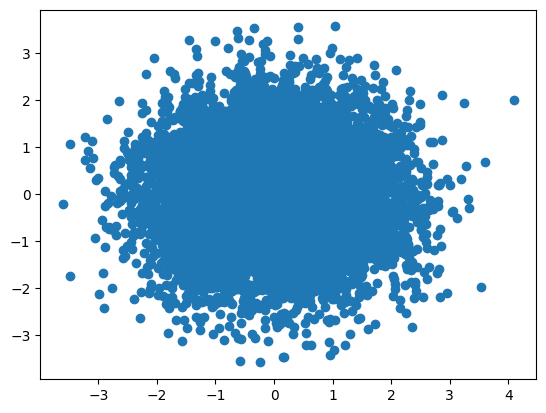

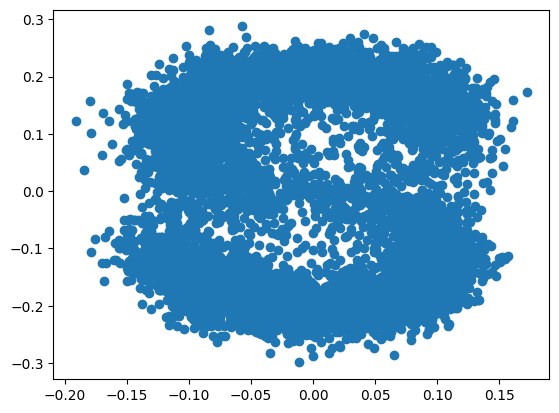

In [12]:
imgs = generate_image(model)

steps_imgs = imgs[::10]
for i in range(len(steps_imgs)):
    plt.figure(i)
    plt.scatter(steps_imgs[i][:, 0], steps_imgs[i][:, 1])

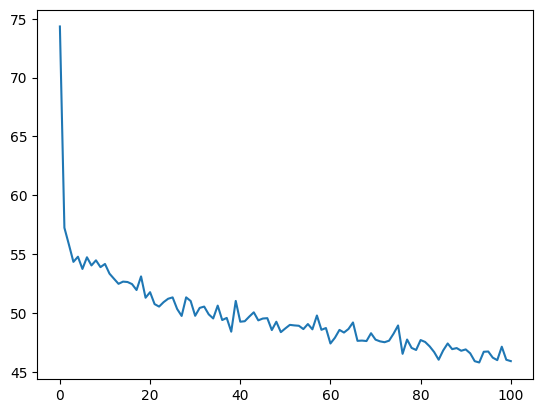

In [13]:
plt.plot(range(0, iters), loss_list)